In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

from sklearn.decomposition import PCA

In [2]:
train, test = pd.read_csv('TrainingData.csv'), pd.read_csv('TestingData.csv')
original_train_x, train_y = np.array(train.iloc[:, :-1]), np.array(train.iloc[:, -1])
original_test_x, test_y = np.array(test.iloc[:, :-1]), np.array(test.iloc[:, -1])
scaler = StandardScaler()
scaler.fit(original_train_x)
train_x = scaler.transform(original_train_x)
test_x = scaler.transform(original_test_x)

## 1.1 Linear Discriminant Analysis

- In the code, I firstyly calculate the vector w in function lda_projection_vector().
- Then given the test data, their labels are predicted throught y = x.dot(w)
- Then I equally split 100 different thresholds between min and max value of y
- Finally, I calculate the accuracy of the prediction given different thresholds and plot the result

In [5]:
# Projection Vector w
def lda_projection_vector(X_train, y_train):
    # Split data into two classes
    class0 = X_train[y_train == 0]
    class1 = X_train[y_train == 1]
    
    # Calculate class means
    mean0 = np.mean(class0, axis=0)
    mean1 = np.mean(class1, axis=0)
    
    # Calculate within-class scatter matrices
    S_w = np.cov(class0, rowvar=False) * len(class0) + np.cov(class1, rowvar=False) * len(class1)
    
    # Compute w as the direction that maximizes the mean separation
    w = np.linalg.inv(S_w).dot(mean1 - mean0)
    return w

# Type1 and Type2 Error with threshold
def compute_error_rates(y_true, y_proj, threshold):
    y_pred = (y_proj >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Type I error (False Positive Rate)
    type1_error = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    
    # Type II error (False Negative Rate)
    type2_error = fn / (fn + tp) if (fn + tp) > 0 else 0.0
    
    return type1_error, type2_error

# Type1 and Type2 Error
def type_errors(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Type I error (False Positive Rate)
    type1_error = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    
    # Type II error (False Negative Rate)
    type2_error = fn / (fn + tp) if (fn + tp) > 0 else 0.0
    
    return type1_error, type2_error

In [43]:
# predict test data
w = lda_projection_vector(train_x, train_y)
y_lda_test = test_x.dot(w)

# Given different thresholds, compute the type 1 and type 2 errors
lda_thresholds = np.linspace(y_lda_test.min(), y_lda_test.max(), 100)
type1_errors = []
type2_errors = []
for threshold in lda_thresholds:
    type1_error, type2_error = compute_error_rates(test_y, y_lda_test, threshold)
    type1_errors.append(type1_error)
    type2_errors.append(type2_error)

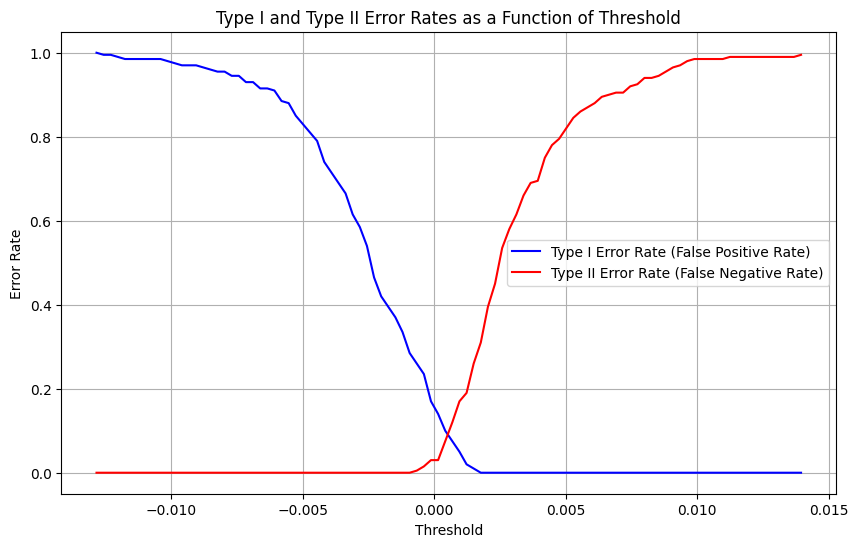

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(lda_thresholds, type1_errors, label="Type I Error Rate (False Positive Rate)", color="blue")
plt.plot(lda_thresholds, type2_errors, label="Type II Error Rate (False Negative Rate)", color="red")
plt.xlabel("Threshold")
plt.ylabel("Error Rate")
plt.title("Type I and Type II Error Rates as a Function of Threshold")
plt.legend()
plt.grid(True)
plt.show()

## 1.2 Decision Tree

Using the existing library DecisionTreeClassifier in sklearn, with parameter max_depth=10, the result is

$$\begin{array}{cc}
\text{Type1 Error} & \text{Type2 Error}\\ \hline
0.145 & 0.11
\end{array}$$

Visualization of the decision tree is also provided

In [45]:
dt = DecisionTreeClassifier(criterion="entropy", max_depth=10, random_state=4)
dt.fit(original_train_x, train_y)
y_dt_test = dt.predict(original_test_x)

In [46]:
dt_t1, dt_t2 = type_errors(test_y, y_dt_test)
print("type1 error rate for decision tree: ", dt_t1)
print("type2 error rate for decision tree: ", dt_t2)

type1 error rate for decision tree:  0.145
type2 error rate for decision tree:  0.11


In [47]:
# Visualize the decision tree
print(tree.export_text(dt, feature_names=list(train.iloc[:, :-1].columns)))

|--- TotalDebtToIncomeRatio <= 0.22
|   |--- TotalDebtToIncomeRatio <= 0.13
|   |   |--- InterestRate <= 0.22
|   |   |   |--- class: 1
|   |   |--- InterestRate >  0.22
|   |   |   |--- Annual Income <= 127607.50
|   |   |   |   |--- Credit Score <= 572.50
|   |   |   |   |   |--- Credit Score <= 462.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Credit Score >  462.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- Credit Score >  572.50
|   |   |   |   |   |--- NetWorth <= 7063.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- NetWorth >  7063.00
|   |   |   |   |   |   |--- Payment History <= 22.50
|   |   |   |   |   |   |   |--- Length of Credit History <= 10.00
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- Length of Credit History >  10.00
|   |   |   |   |   |   |   |   |--- Checking Account Balance <= 4234.00
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- Chec

## 1.3 K-nearest Neighbors

Using the existing library in KNeighborsClassifier() sklearn, given k=1,3,5,10, the result is
$$\begin{array}{ccc}
k & \text{Type1 Error} & \text{Type2 Error}\\ \hline
1 & 0.265 & 0.19\\ 
3 & 0.275 & 0.115\\ 
5 & 0.26 & 0.085\\ 
10 & 0.225 & 0.125\\
\end{array}$$


In [48]:
k_values = [1, 3, 5, 10]
knn_type1 = []
knn_type2 = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_x, train_y)
    y_kn_pred = knn.predict(test_x)
    kn_t1, kn_t2 = type_errors(test_y, y_kn_pred)
    knn_type1.append(kn_t1)
    knn_type2.append(kn_t2)
    print("type1 error rate for kNN in k= ",k, "is", kn_t1)
    print("type2 error rate for kNN in k= ",k, "is", kn_t2)

type1 error rate for kNN in k=  1 is 0.265
type2 error rate for kNN in k=  1 is 0.19
type1 error rate for kNN in k=  3 is 0.275
type2 error rate for kNN in k=  3 is 0.115
type1 error rate for kNN in k=  5 is 0.26
type2 error rate for kNN in k=  5 is 0.085
type1 error rate for kNN in k=  10 is 0.225
type2 error rate for kNN in k=  10 is 0.125


## 1.4 Support Vector Machine

Using existing library Linear SVC from sklearn.
SVC solves the following primal problem:
$$min_{w,b,\zeta}\frac{1}{2}w^Tw+C\sum_{i=1}^n\zeta_i$$
subject to $y_i(w^T\phi(x_i)+b)\geq 1-\zeta_i, \zeta_i\geq 0, i=1,...,n$

In this question, $C=1$. The result is
$$\begin{array}{cc}
\text{Type1 Error} & \text{Type2 Error}\\ \hline
0.13 & 0.03
\end{array}$$

In [3]:
svm = LinearSVC(dual='auto', C=1)
svm.fit(train_x, train_y)
y_svm_pred = svm.predict(test_x)

In [6]:
svm_t1, svm_t2 = type_errors(test_y, y_svm_pred)
print("type1 error rate for svm is", svm_t1)
print("type2 error rate for svm is", svm_t2)

type1 error rate for svm is 0.13
type2 error rate for svm is 0.03


## 2.1 kNN After PCA

Using the existing library PCA in sklearn, given different number of components (5, 10, 15), the results of kNN classifier with different k (1, 3, 5, 10) are
$$\begin{array}{cccc}
kNN & \text{PCA components} & \text{Type1 Error} & \text{Type2 Error}\\ \hline
1 & 5 & 0.21 & 0.165\\
1 & 10 & 0.245 & 0.22\\
1 & 15 & 0.24 & 0.18\\
3 & 5 & 0.175 & 0.12\\
3 & 10 & 0.225 & 0.14\\
3 & 15 & 0.235 & 0.15\\
5 & 5 & 0.18 & 0.115\\
5 & 10 & 0.235 & 0.105\\
5 & 15 & 0.27 & 0.11\\
10 & 5 & 0.16 & 0.095\\
10 & 10 & 0.165 & 0.12\\
10 & 15 & 0.195 & 0.14\\
\end{array}$$

In [8]:
n_com = [5, 10, 15]
pca = [PCA(n_components=n) for n in n_com]
pca_fit = [pca[i].fit_transform(train_x) for i in range(len(pca))]
pca_test_x = [pca[i].transform(test_x) for i in range(len(pca))]

In [9]:
pca_fit[0].shape, pca_fit[1].shape, pca_fit[2].shape, pca_test_x[0].shape, pca_test_x[1].shape, pca_test_x[2].shape

((900, 5), (900, 10), (900, 15), (400, 5), (400, 10), (400, 15))

In [53]:
pca_knn_type1 = []
pca_knn_type2 = []
for k in k_values:
    for i, f in enumerate(pca_fit):
        knn = KNeighborsClassifier(n_neighbors=k, ran)
        knn.fit(pca_fit[i], train_y)
        y_pca_kn_pred = knn.predict(pca_test_x[i])
        pca_kn_t1, pca_kn_t2 = type_errors(test_y, y_pca_kn_pred)
        pca_knn_type1.append(pca_kn_t1)
        pca_knn_type2.append(pca_kn_t2)
        print("type1 error rate for kNN in k= ",k, "and PCA component=", n_com[i], "is", pca_kn_t1)
        print("type2 error rate for kNN in k= ",k, "and PCA component=", n_com[i], "is", pca_kn_t2)

type1 error rate for kNN in k=  1 and PCA component= 5 is 0.21
type2 error rate for kNN in k=  1 and PCA component= 5 is 0.165
type1 error rate for kNN in k=  1 and PCA component= 10 is 0.245
type2 error rate for kNN in k=  1 and PCA component= 10 is 0.22
type1 error rate for kNN in k=  1 and PCA component= 15 is 0.24
type2 error rate for kNN in k=  1 and PCA component= 15 is 0.18
type1 error rate for kNN in k=  3 and PCA component= 5 is 0.175
type2 error rate for kNN in k=  3 and PCA component= 5 is 0.12
type1 error rate for kNN in k=  3 and PCA component= 10 is 0.225
type2 error rate for kNN in k=  3 and PCA component= 10 is 0.14
type1 error rate for kNN in k=  3 and PCA component= 15 is 0.235
type2 error rate for kNN in k=  3 and PCA component= 15 is 0.15
type1 error rate for kNN in k=  5 and PCA component= 5 is 0.18
type2 error rate for kNN in k=  5 and PCA component= 5 is 0.115
type1 error rate for kNN in k=  5 and PCA component= 10 is 0.235
type2 error rate for kNN in k=  5 and P

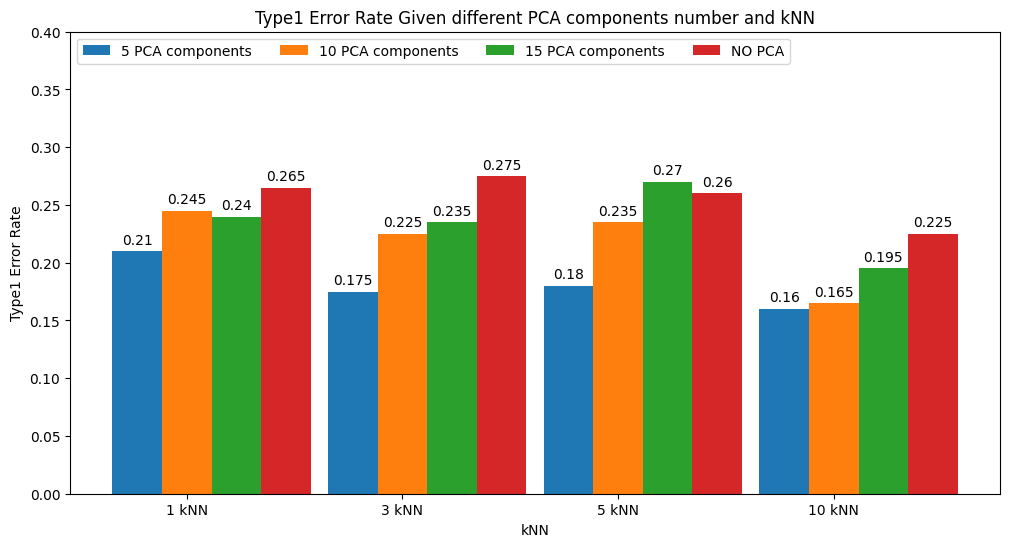

In [54]:
# Type 1
lables = ("1 kNN", "3 kNN", "5 kNN", "10 kNN")
data = {
    '5 PCA components': tuple(pca_knn_type1[0::3]),
    '10 PCA components': tuple(pca_knn_type1[1::3]),
    '15 PCA components' : tuple(pca_knn_type1[2::3]),
    'NO PCA' : tuple(knn_type1)
}
x = np.arange(len(lables))  # the label locations
width = 0.23  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12, 6))

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Type1 Error Rate')
ax.set_xlabel('kNN')
ax.set_title('Type1 Error Rate Given different PCA components number and kNN')
ax.set_xticks(x + width, lables)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 0.4)

plt.show()

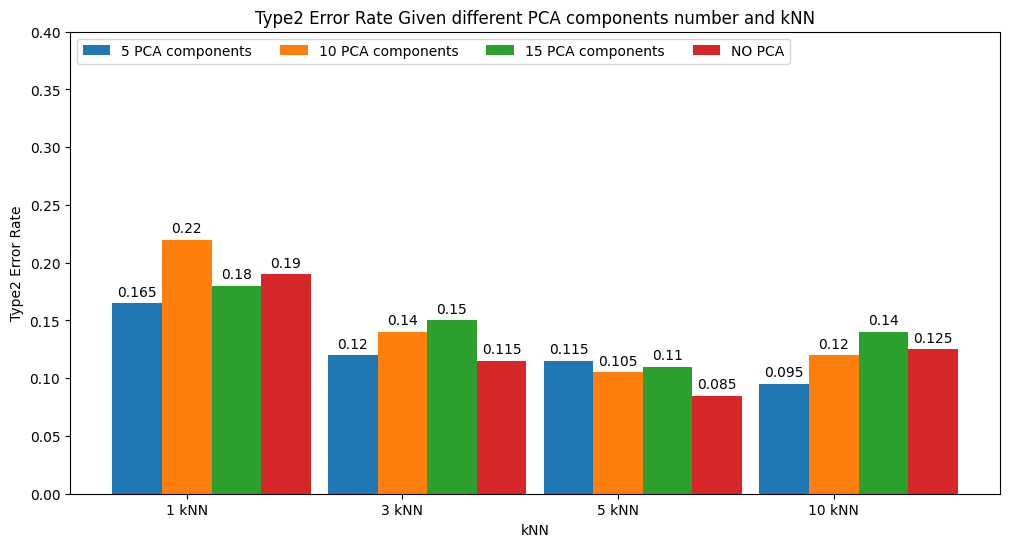

In [55]:
# Type 2
lables = ("1 kNN", "3 kNN", "5 kNN", "10 kNN")
data = {
    '5 PCA components': tuple(pca_knn_type2[0::3]),
    '10 PCA components': tuple(pca_knn_type2[1::3]),
    '15 PCA components' : tuple(pca_knn_type2[2::3]),
    'NO PCA' : tuple(knn_type2)
}
x = np.arange(len(lables))  # the label locations
width = 0.23  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12, 6))

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Type2 Error Rate')
ax.set_xlabel('kNN')
ax.set_title('Type2 Error Rate Given different PCA components number and kNN')
ax.set_xticks(x + width, lables)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 0.4)

plt.show()

We can see in most cases, using PCA can have a similar type1 and type2 error compared to not using PCA. That means the dimensionality reduction with lower principal components can effectively capture the essential features of the data.

Moreover, in type1 error, there is a tendency that dimensionality reduction with smaller principal components have a lover type1 error rate. That is probability because it reduce some noise compare to the original data.

## 2.2 SVM After PCA

Using existing library Linear SVC from sklearn, given different number of components (5, 10, 15), the results of SVM classifier are

$$\begin{array}{cc}
\text{PCA components} & \text{Type1 Error} & \text{Type2 Error}\\ \hline
5 & 0.13 & 0.08\\
10 & 0.16 & 0.07\\
15 & 0.14 & 0.055
\end{array}$$

In [14]:
pca_svm_type1 = []
pca_svm_type2 = []
for i, n in enumerate(n_com):
    svm = LinearSVC(dual='auto', C=1)
    svm.fit(pca_fit[i], train_y)
    y_pca_svm_pred = svm.predict(pca_test_x[i])
    pca_svm_t1, pca_svm_t2 = type_errors(test_y, y_pca_svm_pred)
    pca_svm_type1.append(pca_svm_t1)
    pca_svm_type2.append(pca_svm_t2)
    print("type1 error rate for SVM in PCA component=", n_com[i], "is", pca_svm_t1)
    print("type2 error rate for SVM in PCA component=", n_com[i], "is", pca_svm_t2)

type1 error rate for SVM in PCA component= 5 is 0.13
type2 error rate for SVM in PCA component= 5 is 0.08
type1 error rate for SVM in PCA component= 10 is 0.16
type2 error rate for SVM in PCA component= 10 is 0.07
type1 error rate for SVM in PCA component= 15 is 0.14
type2 error rate for SVM in PCA component= 15 is 0.055


In [16]:
pca_svm_type1, pca_svm_type2

([0.13, 0.16, 0.14], [0.08, 0.07, 0.055])

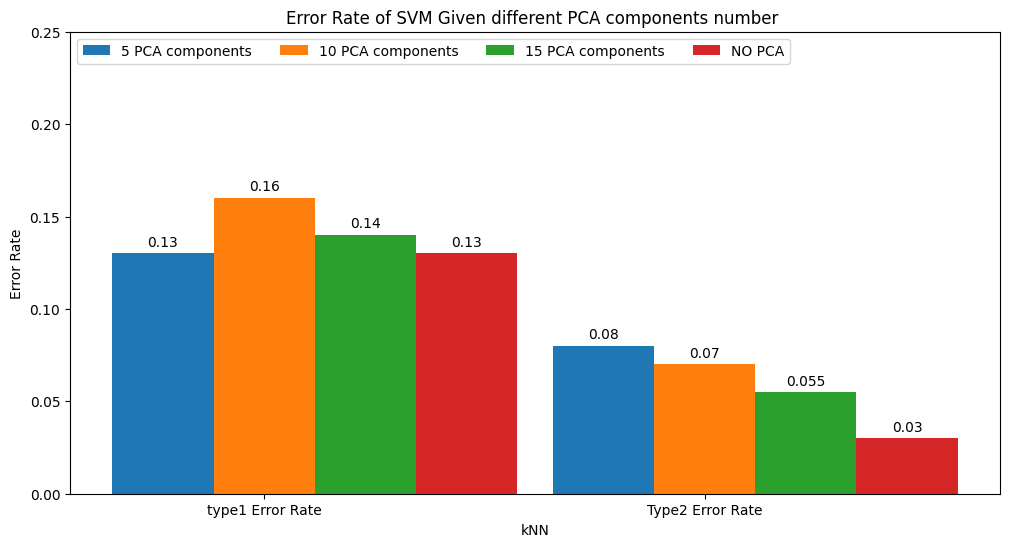

In [23]:
lables = ("type1 Error Rate", "Type2 Error Rate")
data = {
    '5 PCA components': (pca_svm_type1[0], pca_svm_type2[0]),
    '10 PCA components': (pca_svm_type1[1], pca_svm_type2[1]),
    '15 PCA components' : (pca_svm_type1[2], pca_svm_type2[2]),
    'NO PCA' : (svm_t1, svm_t2)
}
x = np.arange(len(lables))  # the label locations
width = 0.23  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12, 6))

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Error Rate')
ax.set_xlabel('kNN')
ax.set_title('Error Rate of SVM Given different PCA components number ')
ax.set_xticks(x + width, lables)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 0.25)

plt.show()

We can see in most cases, using PCA can have a similar type1 and type2 error compared to not using PCA. That means the dimensionality reduction with lower principal components can effectively capture the essential features of the data.

However, when it comes to the Type2 Error Rate, the PCA method Type2 Error Rate has a higher rate than the original data. This is probability because the PCA method is designed to reduce the dimensionality of the data, which may lead to some information loss.